# **1. Loading The Data**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizerFast, TFDistilBertModel



In [2]:

MAX_LENGTH = 50   # keep same as your previous max_length
MODEL_NAME = "distilbert-base-uncased"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
bert = TFDistilBertModel.from_pretrained(MODEL_NAME, from_pt=True)
# optional: freeze BERT weights to speed up training and reduce memory usage
bert.trainable = False

def encode_texts(texts):
    # returns numpy arrays of input_ids and attention_mask padded/truncated to MAX_LENGTH
    enc = tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='tf'
    )
    return enc['input_ids'].numpy(), enc['attention_mask'].numpy()

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the mode

In [3]:
emotion_df = pd.read_csv('emotions.csv')

In [4]:
emotion_df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [5]:
violence_df = pd.read_csv('violence.csv')

In [6]:
violence_df.head()

,Tweet_ID,tweet,type
0,ID_0022DWKP,Had a dream i got raped last night. By a guy i...,sexual_violence
1,ID_00395QYM,he thought the word raped means sex and told m...,sexual_violence
2,ID_003EOSSF,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,sexual_violence
3,ID_004BBHOD,I was sexually abused for 3 years at age 4 to ...,sexual_violence
4,ID_004F7516,Chessy Prout can do better by telling the trut...,sexual_violence


In [7]:
hate_df = pd.read_csv('hate_speech.csv')

In [8]:
hate_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


# **2. Data Preprocessing**

In [9]:
emotion_df.drop(columns= ['Unnamed: 0'], inplace= True)

In [10]:
violence_df.drop(columns= ['Tweet_ID'], inplace= True)

In [11]:
hate_df = hate_df[['tweet', 'class']]

In [12]:
emotion_df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [13]:
violence_df.head()

,tweet,type
0,Had a dream i got raped last night. By a guy i...,sexual_violence
1,he thought the word raped means sex and told m...,sexual_violence
2,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,sexual_violence
3,I was sexually abused for 3 years at age 4 to ...,sexual_violence
4,Chessy Prout can do better by telling the trut...,sexual_violence


In [14]:
hate_df.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [15]:
emotion_df.columns, violence_df.columns, hate_df.columns

(Index(['text', 'label'], dtype='object'),
 Index(['tweet', 'type'], dtype='object'),
 Index(['tweet', 'class'], dtype='object'))

In [16]:
#renaming the columns
violence_df.rename(columns= {'tweet':'text', 'type':'label'}, inplace= True)
hate_df.rename(columns= {'tweet': 'text', 'class':'label'}, inplace= True)

In [17]:
##DATA AUGMENTATION
# --- Text augmentation utilities (EDA) ---
import random
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
import re

# basic tokenization (keeps punctuation separated)
def tokenize(text):
    return re.findall(r"\w+|[^\w\s]", str(text), re.UNICODE)

def detokenize(tokens):
    return " ".join(tokens)

def get_synonyms(word):
    syns = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            w = lemma.name().replace('_', ' ')
            if w.lower() != word.lower():
                syns.add(w)
    return list(syns)

def synonym_replacement(words, n):
    new_words = words.copy()
    eligible_idxs = [i for i,w in enumerate(words) if w.isalpha()]
    random.shuffle(eligible_idxs)
    num_replaced = 0
    for idx in eligible_idxs:
        synonyms = get_synonyms(words[idx])
        if synonyms:
            new_words[idx] = random.choice(synonyms)
            num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

def random_deletion(words, p):
    # randomly delete words with probability p (but keep at least one)
    if len(words) == 1:
        return words
    new_words = []
    for w in words:
        if random.random() > p:
            new_words.append(w)
    if len(new_words) == 0:
        return [random.choice(words)]
    return new_words

def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        idx1 = random.randrange(len(new_words))
        idx2 = random.randrange(len(new_words))
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return new_words

def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        possible_idxs = [i for i,w in enumerate(new_words) if w.isalpha()]
        if not possible_idxs:
            break
        idx = random.choice(possible_idxs)
        syns = get_synonyms(new_words[idx])
        if syns:
            insert_word = random.choice(syns)
            insert_pos = random.randrange(len(new_words)+1)
            new_words.insert(insert_pos, insert_word)
    return new_words

# One-shot EDA function: performs one augmentation variant chosen randomly
def augment_one(text, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1):
    words = tokenize(text)
    n_words = max(1, len(words))
    # number of changes proportional to text length
    n_sr = max(1, int(alpha_sr * n_words))
    n_ri = max(1, int(alpha_ri * n_words))
    n_rs = max(1, int(alpha_rs * n_words))
    aug_choice = random.choice(['sr','ri','rs','rd'])
    if aug_choice == 'sr':
        aug_words = synonym_replacement(words, n_sr)
    elif aug_choice == 'ri':
        aug_words = random_insertion(words, n_ri)
    elif aug_choice == 'rs':
        aug_words = random_swap(words, n_rs)
    else:
        aug_words = random_deletion(words, p_rd)
    return detokenize(aug_words)

# --- Upsample minority class via augmentation ---
from sklearn.utils import resample

def augment_minority(df, label_col='label', text_col='text', minority_label=0, target_count=None,
                     alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, seed=42):
    """
    Augment minority class rows until the minority class reaches target_count.
    If target_count is None, it will be set to max(class_counts).
    Returns a new DataFrame with augmented samples appended.
    """
    random.seed(seed)
    np.random.seed(seed)
    df = df.copy().reset_index(drop=True)
    counts = df[label_col].value_counts()
    if target_count is None:
        target_count = counts.max()
    minority_df = df[df[label_col] == minority_label].copy()
    majority_target = target_count
    current = len(minority_df)
    augmented_rows = []
    idxs = list(minority_df.index)
    i = 0
    while current < majority_target:
        src_idx = random.choice(idxs)
        src_text = df.loc[src_idx, text_col]
        new_text = augment_one(src_text, alpha_sr=alpha_sr, alpha_ri=alpha_ri, alpha_rs=alpha_rs, p_rd=p_rd)
        augmented_rows.append({text_col: new_text, label_col: minority_label})
        current += 1
        i += 1
        if i % 1000 == 0:
            # brief progress print occasionally
            print(f"Augmented {i} samples... current minority size: {current}")
    if augmented_rows:
        aug_df = pd.DataFrame(augmented_rows)
        result = pd.concat([df, aug_df], ignore_index=True).sample(frac=1, random_state=seed).reset_index(drop=True)
    else:
        result = df
    return result

# -------------------------
# EXAMPLE USAGE for your hate_df:
# -------------------------
# hate_df has columns 'text' and 'label' and label 0 is minority (hate)
print("Before augmentation:", hate_df['label'].value_counts())
hate_df_aug = augment_minority(hate_df, label_col='label', text_col='text', minority_label=0, target_count=None,
                               alpha_sr=0.12, alpha_ri=0.08, alpha_rs=0.08, p_rd=0.05, seed=42)
print("After augmentation:", hate_df_aug['label'].value_counts())

# --- Re-tokenize the upsampled hate dataset (and keep emotion/violence unchanged) ---
# assume encode_texts(texts) exists and tokenizer/MAX_LENGTH defined
hate_ids, hate_mask = encode_texts(hate_df_aug['text'])
hate_labels = hate_df_aug['label'].values


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Before augmentation: label
1    19190
2     4163
0     1430
Name: count, dtype: int64
Augmented 1000 samples... current minority size: 2430
Augmented 2000 samples... current minority size: 3430
Augmented 3000 samples... current minority size: 4430
Augmented 4000 samples... current minority size: 5430
Augmented 5000 samples... current minority size: 6430
Augmented 6000 samples... current minority size: 7430
Augmented 7000 samples... current minority size: 8430
Augmented 8000 samples... current minority size: 9430
Augmented 9000 samples... current minority size: 10430
Augmented 10000 samples... current minority size: 11430
Augmented 11000 samples... current minority size: 12430
Augmented 12000 samples... current minority size: 13430
Augmented 13000 samples... current minority size: 14430
Augmented 14000 samples... current minority size: 15430
Augmented 15000 samples... current minority size: 16430
Augmented 16000 samples... current minority size: 17430
Augmented 17000 samples... current 

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


After augmentation: label
1    19190
0    19190
2     4163
Name: count, dtype: int64


In [18]:
emotion_df.isna().sum()

,0
text,0
label,0


In [19]:
violence_df.isna().sum()

,0
text,0
label,0


In [20]:
hate_df.isna().sum()

,0
text,0
label,0


In [21]:
emotion_df.shape, violence_df.shape, hate_df.shape

((416809, 2), (39650, 2), (24783, 2))

In [22]:
emotion_df['label'].value_counts()

,count
label,
1,141067
0,121187
3,57317
4,47712
2,34554
5,14972


In [23]:
e_df = pd.DataFrame()
for i in range(6):
  subset = emotion_df[emotion_df['label']==i].sample(n=2000, random_state = 42)
  e_df = pd.concat([e_df, subset])

In [24]:
emotion_df = e_df.copy()

In [25]:
emotion_df['label'].value_counts()

,count
label,
0,2000
1,2000
2,2000
3,2000
4,2000
5,2000


In [26]:

violence_df['label'].value_counts()

,count
label,
sexual_violence,32648
Physical_violence,5946
emotional_violence,651
economic_violence,217
Harmful_Traditional_practice,188


In [27]:
sexual_violence = violence_df[violence_df['label']=='sexual_violence'].sample(n=4998, random_state = 42)

In [28]:
violence_df = violence_df[violence_df['label']!='sexual_violence']
violence_df.shape

(7002, 2)

In [29]:
violence_df = pd.concat([sexual_violence, violence_df], axis = 0)

In [30]:
violence_df.shape


(12000, 2)

In [31]:
hate_df_aug['label'].value_counts()

,count
label,
1,19190
0,19190
2,4163


In [32]:
offense_1 = hate_df_aug[hate_df_aug['label']==1].sample(n=3918, random_state = 42)
offense_0 = hate_df_aug[hate_df_aug['label']==0].sample(n=3919, random_state = 42)
hate_df_aug = hate_df_aug[(hate_df_aug['label']!= 1) & (hate_df_aug['label']!= 0) ]

In [33]:
hate_df_aug.shape

(4163, 2)

In [34]:
hate_df_aug = pd.concat([offense_1, offense_0, hate_df_aug], axis= 0)

In [35]:
hate_df_aug.shape

(12000, 2)

In [36]:
emotion_df.shape, violence_df.shape, hate_df_aug.shape

((12000, 2), (12000, 2), (12000, 2))

In [37]:
emotion_df.head()

,text,label
133243,ive learned to surround myself with women who ...,0
88501,i already feel crappy because of this and you ...,0
131379,i feel like i have lost mourned and moved past...,0
148369,i could write a whole lot more about why im fe...,0
134438,i always seem to feel inadequate,0


In [38]:
violence_df.head()

,text,label
35209,My cousin was raped by this guy Matthew. She w...,sexual_violence
38191,HAHAHAHAHAHAHHA I DIDN’T SEE IT THE FIRST TIME...,sexual_violence
20925,I remember how I almost got raped like it was ...,sexual_violence
16674,He raped me 👈,sexual_violence
29906,"A woman raped by A male: psychological horror,...",sexual_violence


In [39]:
hate_df_aug.head()

,text,label
39224,Meek mill said get yo game up before you lose ...,1
35206,@Inkedup_Tiny ^___^ still should've walked ove...,1
18089,"""Stop being a pussy, son, and shove that needl...",1
29446,RT @keithscho: Watching the Innocence of Musli...,1
23775,RT @UNCLERUCKUS_BD: Andrew Bynum got traded an...,1


In [40]:
# resetting the indexes
emotion_df.reset_index(drop= True, inplace= True)
violence_df.reset_index(drop= True, inplace= True)
hate_df_aug.reset_index(drop= True, inplace= True)

In [41]:
emotion_df.head()

,text,label
0,ive learned to surround myself with women who ...,0
1,i already feel crappy because of this and you ...,0
2,i feel like i have lost mourned and moved past...,0
3,i could write a whole lot more about why im fe...,0
4,i always seem to feel inadequate,0


In [42]:
violence_df.head()

,text,label
0,My cousin was raped by this guy Matthew. She w...,sexual_violence
1,HAHAHAHAHAHAHHA I DIDN’T SEE IT THE FIRST TIME...,sexual_violence
2,I remember how I almost got raped like it was ...,sexual_violence
3,He raped me 👈,sexual_violence
4,"A woman raped by A male: psychological horror,...",sexual_violence


In [43]:
hate_df = hate_df_aug.copy()

In [44]:
hate_df.head()

,text,label
0,Meek mill said get yo game up before you lose ...,1
1,@Inkedup_Tiny ^___^ still should've walked ove...,1
2,"""Stop being a pussy, son, and shove that needl...",1
3,RT @keithscho: Watching the Innocence of Musli...,1
4,RT @UNCLERUCKUS_BD: Andrew Bynum got traded an...,1


# **3. Label Encoding**

In [45]:
label_encoder = LabelEncoder()
violence_df['label'] = label_encoder.fit_transform(violence_df['label'])

In [46]:
violence_df.head()

,text,label
0,My cousin was raped by this guy Matthew. She w...,4
1,HAHAHAHAHAHAHHA I DIDN’T SEE IT THE FIRST TIME...,4
2,I remember how I almost got raped like it was ...,4
3,He raped me 👈,4
4,"A woman raped by A male: psychological horror,...",4


# **4. Text Preprocessing**

In [47]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
#loading the stopwords
stop_words = set(stopwords.words('english'))

In [49]:
len(stop_words)

198

In [50]:
#stopwords removal

def remove_stopwords(text):
  all_words = nltk.word_tokenize(text)
  filtered_words = [word for word in all_words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

emotion_df['text'] = emotion_df['text'].apply(remove_stopwords)
violence_df['text'] = violence_df['text'].apply(remove_stopwords)
hate_df['text'] = hate_df['text'].apply(remove_stopwords)


In [51]:
emotion_df.head(3)

,text,label
0,ive learned surround women lift leave feeling ...,0
1,already feel crappy upset situation doesnt help,0
2,feel like lost mourned moved past tears relati...,0


In [52]:
violence_df.head(3)

,text,label
0,cousin raped guy Matthew . using restroom . Ma...,4
1,HAHAHAHAHAHAHHA ’ SEE FIRST TIME ’ WROTE ’ « D...,4
2,remember almost got raped like yesterday . pul...,4


In [53]:
hate_df.head(3)

,text,label
0,Meek mill said get yo game lose yo bitch damn lol,1
1,@ Inkedup_Tiny ^___^ still 've walked said som...,1
2,"`` Stop pussy , son , shove needle heart ! '' ...",1


In [54]:
!pip install safetensors --upgrade

# **5. Tokenization & Padding**

In [55]:
emotion_ids, emotion_mask = encode_texts(emotion_df['text'])
violence_ids, violence_mask = encode_texts(violence_df['text'])
hate_ids, hate_mask = encode_texts(hate_df['text'])

In [56]:
# labels
emotion_labels = np.array(emotion_df['label'])
violence_labels = np.array(violence_df['label'])
hate_labels = np.array(hate_df['label'])


In [57]:
import tensorflow as tf
from tensorflow import keras

# For each task we create two inputs: input_ids and attention_mask (so 6 inputs in total)
e_input_ids = keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='emotion_input_ids')
e_attention  = keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='emotion_attention_mask')

v_input_ids = keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='violence_input_ids')
v_attention = keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='violence_attention_mask')

h_input_ids = keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='hate_input_ids')
h_attention = keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='hate_attention_mask')

In [58]:
class TFDistilBertLayer(keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super().__init__(**kwargs)
        self.bert = bert_model
        # hidden size from config (e.g., 768)
        self.hidden_size = int(getattr(self.bert.config, "hidden_size", 768))

    def call(self, inputs, training=False):
        # inputs is a list/tuple: [input_ids, attention_mask]
        input_ids, attention_mask = inputs
        # call the TFDistilBertModel (will accept KerasTensors here)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, training=training)
        # return sequence output: shape (batch, seq_len, hidden_size)
        return outputs.last_hidden_state

    def compute_output_shape(self, input_shape):
        # input_shape is something like: [(batch, seq_len), (batch, seq_len)]
        batch = input_shape[0][0]
        seq_len = input_shape[0][1]
        return (batch, seq_len, self.hidden_size)

# create the wrapper layer once
bert_layer = TFDistilBertLayer(bert, name="tf_distilbert_layer")

# now call it with Keras Input tensors to get symbolic sequence tensors
e_bert_seq = bert_layer([e_input_ids, e_attention])   # shape: (None, MAX_LENGTH, hidden_size)
v_bert_seq = bert_layer([v_input_ids, v_attention])
h_bert_seq = bert_layer([h_input_ids, h_attention])

# proceed with your shared LSTM and heads
shared_lstm = keras.layers.LSTM(64, return_sequences=True, name='shared_lstm')

e_lstm = shared_lstm(e_bert_seq)
v_lstm = shared_lstm(v_bert_seq)
h_lstm = shared_lstm(h_bert_seq)

shared_pool = keras.layers.GlobalAveragePooling1D()
shared_dropout = keras.layers.Dropout(0.5)

e_feat = shared_dropout(shared_pool(e_lstm))
v_feat = shared_dropout(shared_pool(v_lstm))
h_feat = shared_dropout(shared_pool(h_lstm))

emotion_output = keras.layers.Dense(6, activation='softmax', name='emotion_output')(e_feat)
violence_output = keras.layers.Dense(5, activation='softmax', name='violence_output')(v_feat)
hate_output = keras.layers.Dense(3, activation='softmax', name='hate_output')(h_feat)

model = keras.models.Model(
    inputs=[
        e_input_ids, e_attention,
        v_input_ids, v_attention,
        h_input_ids, h_attention
    ],
    outputs=[emotion_output, violence_output, hate_output]
)

model.compile(
    optimizer='adam',
    loss={
        'emotion_output': 'sparse_categorical_crossentropy',
        'violence_output': 'sparse_categorical_crossentropy',
        'hate_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'emotion_output': 'accuracy',
        'violence_output': 'accuracy',
        'hate_output': 'accuracy'
    }
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ emotion_input_ids   │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_attention_… │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ violence_input_ids  │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ violence_attention… │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hate_input_ids      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hate_attention_mask │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tf_distilbert_layer │ (None, 50, 768)   │          0 │ emotion_input_id… │
│ (TFDistilBertLayer) │                   │            │ emotion_attentio… │
│                     │                   │            │ violence_input_i… │
│                     │                   │            │ violence_attenti… │
│                     │                   │            │ hate_input_ids[0… │
│                     │                   │            │ hate_attention_m… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_lstm (LSTM)  │ (None, 50, 64)    │    213,248 │ tf_distilbert_la… │
│                     │                   │            │ tf_distilbert_la… │
│                     │                   │            │ tf_distilbert_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ shared_lstm[0][0… │
│ (GlobalAveragePool… │                   │            │ shared_lstm[1][0… │
│                     │                   │            │ shared_lstm[2][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ global_average_p… │
│                     │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_output      │ (None, 6)         │        390 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ violence_output     │ (None, 5)         │        325 │ dropout[1][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hate_output (Dense) │ (None, 3)         │        195 │ dropout[2][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 214,158 (836.55 KB)

 Trainable params: 214,158 (836.55 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# ----------------------------
# Replace your previous TRAINING block with this
# ----------------------------
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

# 1) Split each dataset into train / temp (where temp will be split into val & test)
def make_splits(ids, masks, labels, test_size=0.2):
    train_ids, temp_ids, train_masks, temp_masks, train_labels, temp_labels = train_test_split(
        ids, masks, labels, test_size=test_size, random_state=RANDOM_STATE, stratify=labels
    )
    # now split temp into val and test equally (so each gets test_size/2 of original -> 0.1 each if test_size=0.2)
    val_ids, test_ids, val_masks, test_masks, val_labels, test_labels = train_test_split(
        temp_ids, temp_masks, temp_labels, test_size=0.5, random_state=RANDOM_STATE, stratify=temp_labels
    )
    return (train_ids, train_masks, train_labels), (val_ids, val_masks, val_labels), (test_ids, test_masks, test_labels)

# Emotion splits
(e_train_ids, e_train_mask, e_train_y), (e_val_ids, e_val_mask, e_val_y), (e_test_ids, e_test_mask, e_test_y) = \
    make_splits(emotion_ids, emotion_mask, emotion_labels, test_size=0.2)

# Violence splits
(v_train_ids, v_train_mask, v_train_y), (v_val_ids, v_val_mask, v_val_y), (v_test_ids, v_test_mask, v_test_y) = \
    make_splits(violence_ids, violence_mask, violence_labels, test_size=0.2)

# Hate splits
(h_train_ids, h_train_mask, h_train_y), (h_val_ids, h_val_mask, h_val_y), (h_test_ids, h_test_mask, h_test_y) = \
    make_splits(hate_ids, hate_mask, hate_labels, test_size=0.2)

# 2) Build input dictionaries for train/val/test (names must match model Input layers)
train_inputs = {
    'emotion_input_ids': e_train_ids,
    'emotion_attention_mask': e_train_mask,
    'violence_input_ids': v_train_ids,
    'violence_attention_mask': v_train_mask,
    'hate_input_ids': h_train_ids,
    'hate_attention_mask': h_train_mask
}

val_inputs = {
    'emotion_input_ids': e_val_ids,
    'emotion_attention_mask': e_val_mask,
    'violence_input_ids': v_val_ids,
    'violence_attention_mask': v_val_mask,
    'hate_input_ids': h_val_ids,
    'hate_attention_mask': h_val_mask
}

test_inputs = {
    'emotion_input_ids': e_test_ids,
    'emotion_attention_mask': e_test_mask,
    'violence_input_ids': v_test_ids,
    'violence_attention_mask': v_test_mask,
    'hate_input_ids': h_test_ids,
    'hate_attention_mask': h_test_mask
}

train_labels = {
    'emotion_output': e_train_y,
    'violence_output': v_train_y,
    'hate_output': h_train_y
}
val_labels = {
    'emotion_output': e_val_y,
    'violence_output': v_val_y,
    'hate_output': h_val_y
}
test_labels = {
    'emotion_output': e_test_y,
    'violence_output': v_test_y,
    'hate_output': h_test_y
}

# 3) Fit the model with validation_data
history = model.fit(
    x=train_inputs,
    y=train_labels,
    epochs=10,            # tune as needed
    batch_size=8,
    validation_data=(val_inputs, val_labels),
    shuffle=True
)



Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 119s 75ms/step - emotion_output_accuracy: 0.3512 - emotion_output_loss: 1.5620 - hate_output_accuracy: 0.5832 - hate_output_loss: 0.8814 - loss: 2.8927 - violence_output_accuracy: 0.8528 - violence_output_loss: 0.4492 - val_emotion_output_accuracy: 0.5617 - val_emotion_output_loss: 1.1550 - val_hate_output_accuracy: 0.7525 - val_hate_output_loss: 0.6081 - val_loss: 1.8818 - val_violence_output_accuracy: 0.9683 - val_violence_output_loss: 0.1188
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 125s 66ms/step - emotion_output_accuracy: 0.5430 - emotion_output_loss: 1.1930 - hate_output_accuracy: 0.7416 - hate_output_loss: 0.6331 - loss: 1.9504 - violence_output_accuracy: 0.9593 - violence_output_loss: 0.1243 - val_emotion_output_accuracy: 0.6633 - val_emotion_output_loss: 0.9259 - val_hate_output_accuracy: 0.7992 - val_hate_output_loss: 0.4946 - val_loss: 1.4801 - val_violence_output_accuracy: 0.9800 - val_violence_output_loss: 0.0596
Epoch 3/10
1200/12

In [60]:
# 4) Evaluate on the held-out test set
print("\n--- Test set evaluation ---")
test_eval = model.evaluate(x=test_inputs, y=test_labels, batch_size=32, return_dict=True)
print(test_eval)

# 5) Predictions on the test set for confusion matrices
preds = model.predict(test_inputs)
emotion_pred_test = np.argmax(preds[0], axis=1)
violence_pred_test = np.argmax(preds[1], axis=1)
hate_pred_test = np.argmax(preds[2], axis=1)


--- Test set evaluation ---
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - emotion_output_accuracy: 0.8672 - emotion_output_loss: 0.4005 - hate_output_accuracy: 0.8529 - hate_output_loss: 0.4414 - loss: 0.8688 - violence_output_accuracy: 0.9918 - violence_output_loss: 0.0268
{'emotion_output_accuracy': 0.8816666603088379, 'emotion_output_loss': 0.3621596395969391, 'hate_output_accuracy': 0.8600000143051147, 'hate_output_loss': 0.43459275364875793, 'loss': 0.8185401558876038, 'violence_output_accuracy': 0.9950000047683716, 'violence_output_loss': 0.020113136619329453}
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 280ms/step


In [61]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# replace with your test true/pred arrays
y_true_e, y_pred_e = e_test_y, emotion_pred_test
y_true_v, y_pred_v = v_test_y, violence_pred_test
y_true_h, y_pred_h = h_test_y, hate_pred_test

print("Emotion report:\n", classification_report(y_true_e, y_pred_e, zero_division=0))
print("Violence report:\n", classification_report(y_true_v, y_pred_v, zero_division=0))
print("Hate report:\n", classification_report(y_true_h, y_pred_h, zero_division=0))


Emotion report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       200
           1       0.92      0.80      0.85       200
           2       0.83      0.95      0.89       200
           3       0.88      0.92      0.90       200
           4       0.84      0.79      0.81       200
           5       0.89      0.93      0.91       200

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.88      1200
weighted avg       0.88      0.88      0.88      1200

Violence report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00       595
           2       0.95      1.00      0.98        21
           3       0.96      1.00      0.98        65
           4       1.00      0.99      0.99       500

    accuracy                           0.99      1200
   macro avg       0.98      1.00      0.9

In [62]:
def plot_cm(true_labels, pred_labels, title,figsize=(7,6)):
    cm = confusion_matrix(true_labels, pred_labels, normalize='true')

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        cmap='Blues',
        fmt=".2f"
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

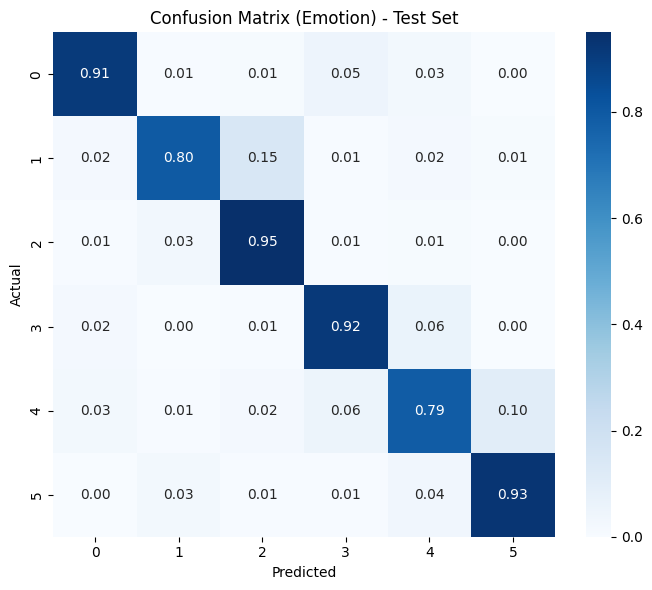

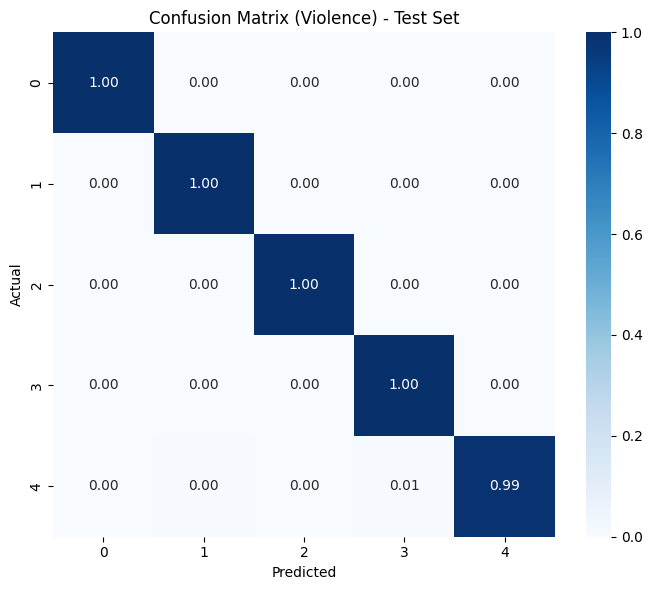

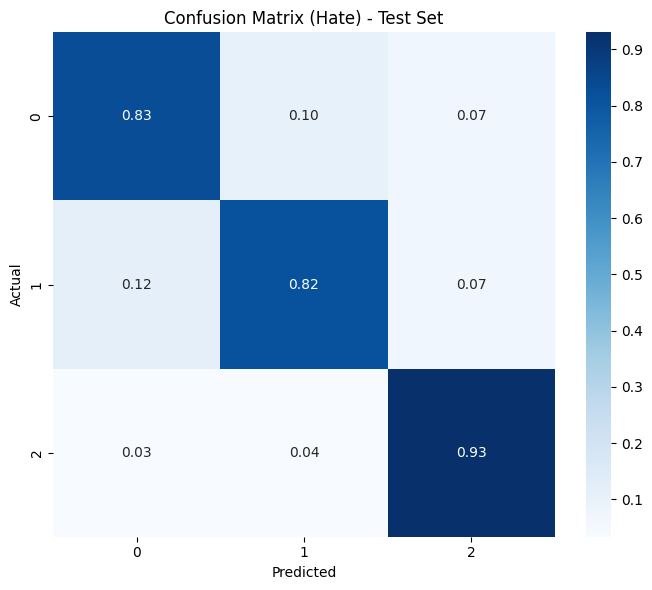

In [63]:
plot_cm(e_test_y, emotion_pred_test,
        'Confusion Matrix (Emotion) - Test Set')

plot_cm(v_test_y, violence_pred_test,
        'Confusion Matrix (Violence) - Test Set')

plot_cm(h_test_y, hate_pred_test,
        'Confusion Matrix (Hate) - Test Set')


In [71]:
def classify_text(input_text):
    """
    Returns (major_label, sub_label, confidence)
    major_label: one of 'Emotion', 'Violence', 'Hate'
    sub_label: predicted subclass name (e.g., 'joy' or 'offensive_speech')
    confidence: float probability of the chosen sub_label
    """
    # 1) clean text (same preprocessing you used for training)
    cleaned = remove_stopwords(input_text)

    # 2) tokenize with DistilBERT tokenizer -> get numpy arrays
    enc = tokenizer(
        cleaned,
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='np'
    )
    input_ids = enc['input_ids']
    attention_mask = enc['attention_mask']

    # 3) build the multi-input dict expected by your model
    single_inputs = {
        'emotion_input_ids': input_ids,
        'emotion_attention_mask': attention_mask,
        'violence_input_ids': input_ids,
        'violence_attention_mask': attention_mask,
        'hate_input_ids': input_ids,
        'hate_attention_mask': attention_mask,
    }

    # 4) predict (model returns list/tuple of outputs for your 3 heads)
    preds = model.predict(single_inputs)

    # 5) extract predicted classes and confidences
    e_probs = preds[0][0]   # shape (num_emotion_classes,)
    v_probs = preds[1][0]
    h_probs = preds[2][0]

    e_idx = int(np.argmax(e_probs))
    v_idx = int(np.argmax(v_probs))
    h_idx = int(np.argmax(h_probs))

    e_conf = float(np.max(e_probs))
    v_conf = float(np.max(v_probs))
    h_conf = float(np.max(h_probs))

    # 6) decide major label by highest confidence among the three tasks
    major_labels = ['Emotion', 'Violence', 'Hate']
    major_index = int(np.argmax([e_conf, v_conf, h_conf]))
    major_label = major_labels[major_index]

    # 7) label name lists (reuse your existing mappings)
    emotion_labels_text = ['sadness','joy','love','anger','fear','surprise']
    violence_labels_text = label_encoder.classes_.tolist()   # ensure label_encoder exists
    hate_labels_text = ['hate_speech','offensive_speech','neither']

    # 8) choose sublabel and confidence based on major_label
    if major_label == 'Emotion':
        sub_label = emotion_labels_text[e_idx]
        confidence = e_conf
    elif major_label == 'Violence':
        sub_label = violence_labels_text[v_idx]
        confidence = v_conf
    else:
        sub_label = hate_labels_text[h_idx]
        confidence = h_conf

    return major_label, sub_label, confidence

In [73]:
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output

# Text Input
input_text_widget = widgets.Text(
    description='Input:',
    placeholder='Enter text here...',
    layout=widgets.Layout(width="600px")
)

# Classify Button
button = widgets.Button(
    description='Classify',
    button_style='primary',
    tooltip='Click to classify text'
)

# Output Box
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()

        text = input_text_widget.value.strip()
        if text == "":
            display(Markdown("⚠️ Please enter some text."))
            return

        try:
            # Your classify_text returns EXACTLY 3 values
            major_label, sub_label, confidence = classify_text(text)
        except Exception as e:
            display(Markdown(f"❌ Error: `{e}`"))
            return

        # Display results
        display(Markdown(f"### 🔍 **Major Category:** {major_label}"))
        display(Markdown(f"### 🏷️ **Sub-Category:** {sub_label}"))
        display(Markdown(f"### 📊 **Confidence:** `{confidence:.4f}`"))

# Bind event
button.on_click(on_button_clicked)

# Display widgets
display(input_text_widget)
display(button)
display(output)

Text(value='', description='Input:', layout=Layout(width='600px'), placeholder='Enter text here...')

Button(button_style='primary', description='Classify', style=ButtonStyle(), tooltip='Click to classify text')

Output()